# Aprendizagem de Máquina I - 2023/02

## Hugo Tremonte de Carvalho

#### hugo@dme.ufrj.br

#### Google Classroom: `zqdk53w`

Este notebook é correspondente ao nosso terceiro projeto, passado no dia 25/11/2023 e para entrega no dia 17/12/2023 (data improrrogável). A entrega da atividade deve ser feita através do Google Classroom, fazendo um upload deste notebook, devidamente atualizado com suas implementações e explicações. Recomendo fortemente que façam o trabalho no Google Colab, pois assim temos certa garantia de estarmos rodando tudo no mesmo ambiente, e eu conseguir executar o código de vocês sem dificuldades.

O projeto poderá ser feito **até** em dupla: quem quer fazer sozinho/a faz, mas quem quiser fazer em dupla também tem esse direito. Porém, vamos evitar problemas de "eu fiz tudo e ele/a não fez nada"! Infelizmente não tenho como controlar isso, e após o projeto entregue não adianta "eu fiz tudo sozinho/a", pois eu não estava lá para ver! Tentem se resolver entre si, mas em último caso posso auxiliar com uma mediação.

# <center> Este é o enunciado do nosso terceiro (e último!) projeto. Por favor o leia com atenção, pois todas as instruções e objetivos estão detalhados aqui! </center>

O objetivo deste trabalho é analisar [esta](https://www.kaggle.com/fmena14/volcanoesvenus) base de dados, que contém imagens de satélite da superfície de Vênus, e deseja-se estudar a ocorrência ou não de vulcões na superfície do planeta. A base de dados está contida no arquivo `dataset.zip`, anexo junto com essa atividade no Google Classroom, e mais abaixo irei detalhar os seus 4 arquivos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Eis aqui o conjunto de treinamento. Você pode (e deve!) fazer validação cruzada nele para comparar diversos classificadores, mas o conjunto de teste será mostrado mais abaixo. Note que não há necessidade de fazer `train_test_split` com a base carregada a seguir, pois mais adiante carregaremos o arquivo com o conjunto de teste!

In [2]:
feat = pd.read_csv('train_images.csv', header = None) # 'header = None' é importante pois o .csv não tem cabeçalho
resp = pd.read_csv('train_labels.csv')

display(feat)

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,90,96,88,95,94,100,95,80,80,71,...,88,83,72,76,73,79,76,79,84,69
6996,82,82,84,91,74,61,73,80,75,97,...,100,78,90,88,80,88,90,90,66,71
6997,133,102,121,133,129,131,98,121,123,125,...,120,123,119,111,104,102,119,130,131,111
6998,118,117,115,107,92,76,100,102,81,106,...,104,105,102,111,99,90,105,100,100,109


Cada linha do dataframe são os pixels de uma imagem em tons de cinza de tamanho 110 x 110, "achatados" em um vetor de tamanho 12.100.

Note que cada pixel corresponde a um valor inteiro entre 0 (totalmente preto) e 255 (totalmente branco). Talvez seja conveniente transformá-los em um número entre 0 e 1.

Vamos ver algumas das imagens na base de dados:

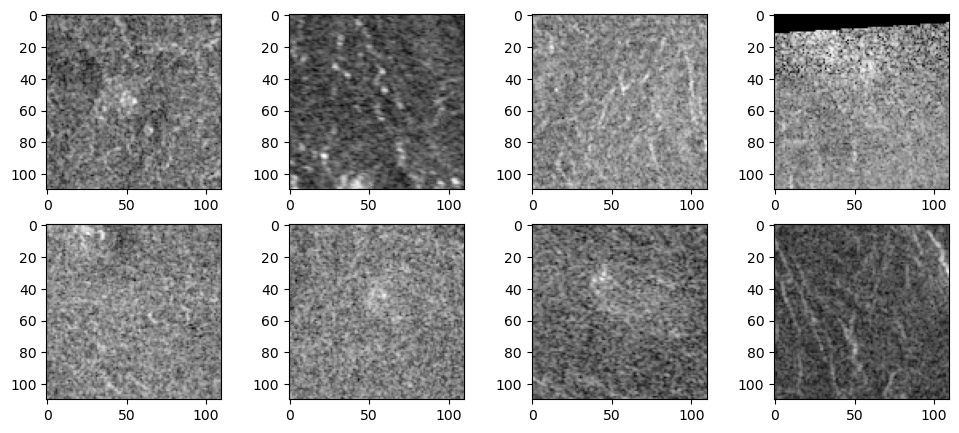

In [3]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 5)
ind = 0

for ax in axs.flat:
    img = np.array(feat.iloc[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

Agora, vamos entender as variáveis resposta:

In [4]:
resp.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


Eis o que cada informação na variável resposta significa:

 * Se ``Volcano? = 0``, então na respectiva imagem acredita-se fortemente que **não** há um vulcão
 * Se ``Volcano? = 1``, então acredita-se fortemente que naquela imagem há ao menos um vulcão, e nesse caso há informações adicionais:
   - ``Number Volcanoes`` representa quantos vulcões provavelmente há naquela imagem (nesse caso, há um vulcão centralizado na figura)
   - ``Radius`` é o raio do vulcão que está centralizado na imagem, medido em *pixels*
   - ``Type`` é uma variável que codifica a incerteza dos astrônomos sobre a existência de um vulcão naquela imagem:
     - ``Type = 1`` indica que a figura respectiva CERTAMENTE contém ao menos um vulcão
     - ``Type = 2`` indica que a figura respectiva PROVAVELMENTE contém ao menos um vulcão
     - ``Type = 3`` indica que a figura respectiva POSSIVELMENTE contém ao menos um vulcão
     - ``Type = 4`` indica que a figura respectiva mostra somente uma cratera

*Obs.: No caso de ``Volcano? = 0``, as outras variáveis são preenchidas com ``NaN``*

Note que a base de dados está desbalanceada.

Obs.: Gráfico de pizza só pra não perder a oportunidade de falar mal do gráfico de pizza e recomendar fortemente que vocês NÃO façam esse tipo de gráfico! :-)

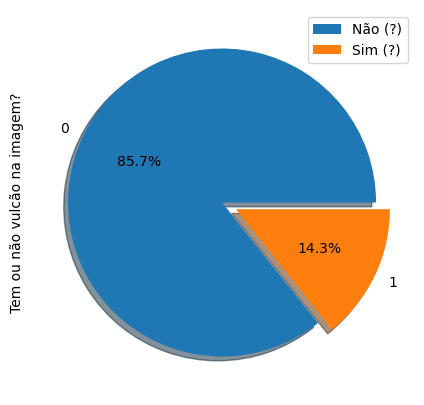

In [5]:
resp['Volcano?'].value_counts().plot(
    kind = 'pie', explode = [0, 0.1], figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
plt.ylabel('Tem ou não vulcão na imagem?')
plt.legend(['Não (?)', 'Sim (?)'])
plt.show()

Dentre as imagens que acredita-se ter um vulcão, vamos ver a distribuição dos quatro graus de incerteza possíveis:

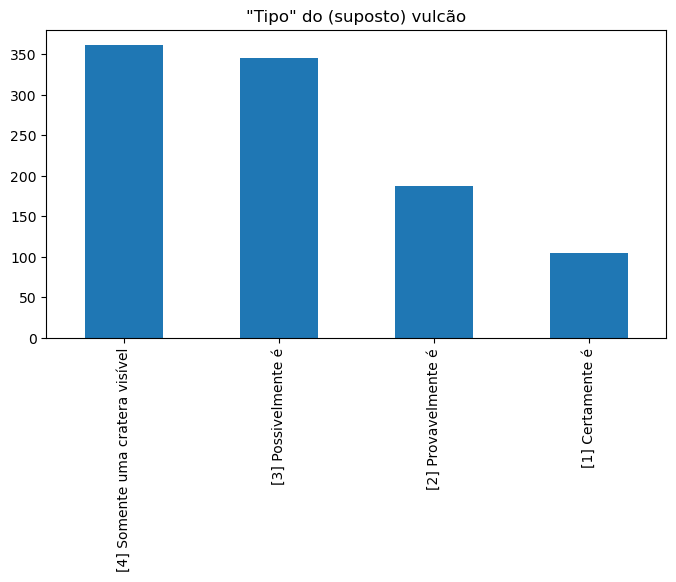

In [6]:
resp[resp['Volcano?'] == 1]['Type'].value_counts().plot(kind = 'bar', legend = False, figsize = (8, 4))
plt.title('"Tipo" do (suposto) vulcão')
plt.xticks(np.arange(4), ['[4] Somente uma cratera visível', '[3] Possivelmente é', '[2] Provavelmente é', '[1] Certamente é'])
plt.show()

Temos uma variável resposta contínua, que é o raio do vulcão:

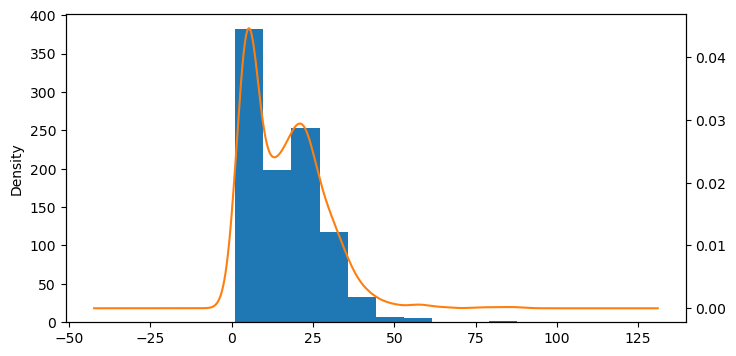

In [7]:
ax = resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'hist', legend = False, figsize = (8, 4))
resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'kde', ax = ax, secondary_y = True)
plt.show()

Finalmente, estudando a quantidade suposta de vulcões na imagem:

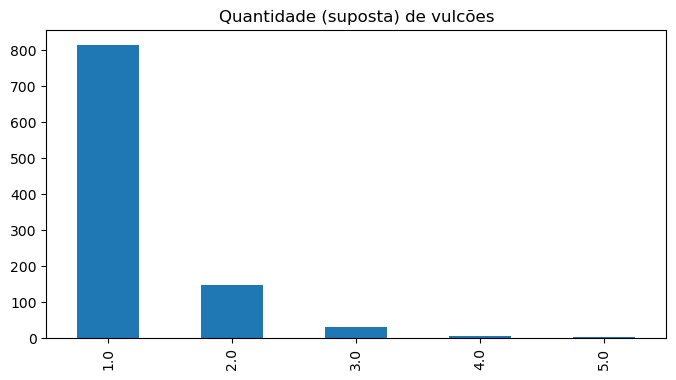

In [8]:
plt.title('Quantidade (suposta) de vulcões')
resp[resp['Volcano?'] == 1]['Number Volcanoes'].value_counts().plot(kind = 'bar', legend = False, figsize = (8, 4))
plt.show()

Agora, vejamos alguns exemplos de imagens da base de dados com diversas das características vistas acima:

== IMAGEM SEM VULCÃO ==
Volcano?            0.0
Type                NaN
Radius              NaN
Number Volcanoes    NaN
Name: 1, dtype: float64


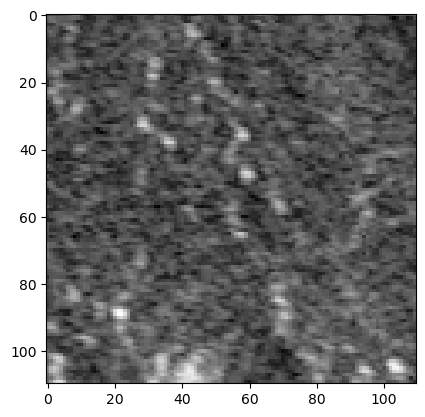

In [9]:
print('== IMAGEM SEM VULCÃO ==')

print(resp.iloc[1])

image = np.array(feat.iloc[1]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 1.00
Radius              22.02
Number Volcanoes     1.00
Name: 9, dtype: float64


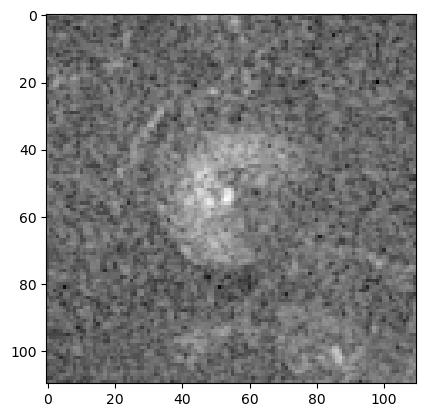

In [10]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[9])

image = np.array(feat.iloc[9]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 2.00
Radius              19.31
Number Volcanoes     1.00
Name: 38, dtype: float64


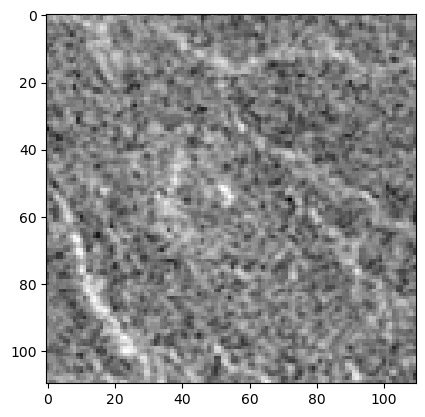

In [11]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[38])

image = np.array(feat.iloc[38]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 3.00
Radius              17.46
Number Volcanoes     1.00
Name: 0, dtype: float64


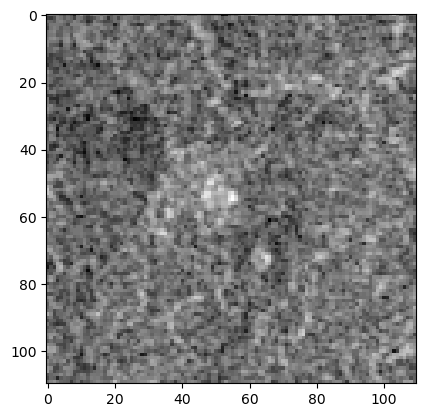

In [12]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[0])

image = np.array(feat.iloc[0]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?            1.0
Type                4.0
Radius              8.0
Number Volcanoes    2.0
Name: 55, dtype: float64


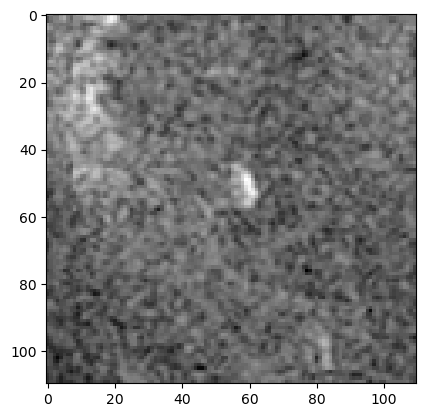

In [13]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[55])

image = np.array(feat.iloc[55]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 3.00
Radius              21.63
Number Volcanoes     2.00
Name: 34, dtype: float64


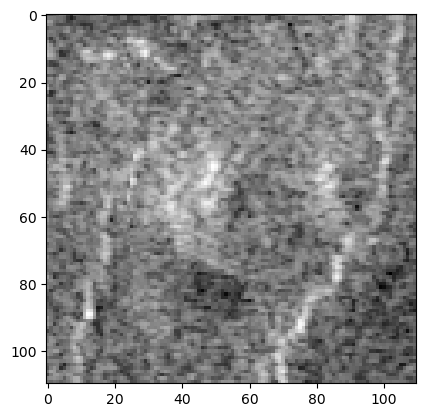

In [14]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[34])

image = np.array(feat.iloc[34]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 2.00
Radius              24.33
Number Volcanoes     3.00
Name: 596, dtype: float64


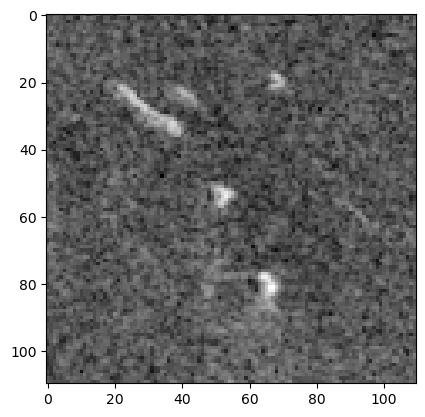

In [15]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[596])

image = np.array(feat.iloc[596]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?            1.00
Type                4.00
Radius              3.61
Number Volcanoes    4.00
Name: 425, dtype: float64


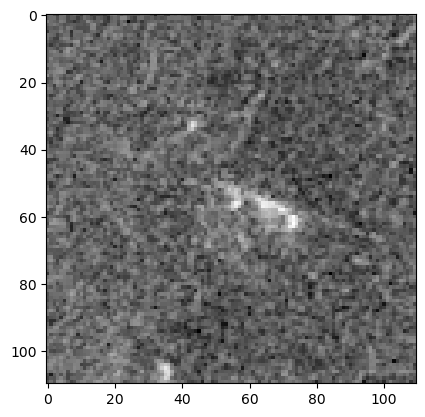

In [16]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[425])

image = np.array(feat.iloc[425]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?            1.00
Type                3.00
Radius              5.83
Number Volcanoes    5.00
Name: 853, dtype: float64


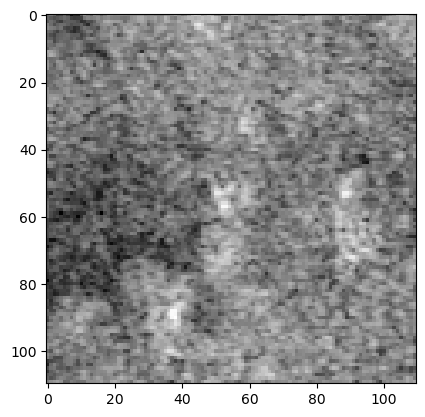

In [17]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[853])

image = np.array(feat.iloc[853]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

## Objetivo

O principal objetivo do projeto é o seguinte:

* Prever, **somente a partir da imagem**, se naquela foto há ou não um vulcão. Ou seja, deve ser resolvido o problema de **classificação binária** onde os dados observados são as linhas do DataFrame ``feat`` e a variável resposta é a coluna ``Volcano?`` do DataFrame ``resp``.

Para isso, você deverá testar todos os classificadores que aprendemos no curso (Naive Bayes, LDA, QDA, SVM, KNN e métodos baseados em árvores), otimizar os hiperparâmetros (quando pertinente) e escolher qual é o melhor classificador de cada classe, utilizando o conjunto de treinamento. Finalmente, compare o desempenho de todos eles no conjunto de teste, e decida por um classificador bom para esse problema.

Como de costume, o treinamento dos classificadores e a validação cruzada para otimização dos hiperparâmetros é um procedimento a ser realizado somente no conjunto de **treinamento**, já carregado. A performance dos melhores classificadores elencados deve ser aferida no conjunto de **teste**, carregado abaixo:

In [18]:
feat_test = pd.read_csv('test_images.csv', header = None)
resp_test = pd.read_csv('test_labels.csv')

### Informações importantes

* Justifique se você deve tomar mais cuidado com falsos negativos ou falsos positivos no objetivo do projeto.


* Você deve entregar:
  - Um Notebook do Jupyter contendo os seus códigos.
  - Células de *markdown* neste notebook, na forma de um relatório, explicando o procedimento que te levou a tais classificadores, como se fosse um resumo de sua investigação. Entregar somente códigos sem explicação **não** é suficiente! Eu tenho que conseguir entender quais foram suas ideias e desenvolvimentos **somente a partir do texto**, sem ter que recorrer ao código. Isso é importante para vocês treinarem a escrita!


* Algumas observações:
  - Descreva o resultado que você obteve, e não somente mostre métricas sem justificativa.
  - A base de dados é **bastante** pesada: 7.000 observações de 12.100 atributos (olha o cenário $p > n$ aí!). Caso você opte por rodar localmente em sua máquina, dependendo da configuração dela, alguns algoritmos podem apanhar um pouco para finalizarem a sua execução. Eu não acredito que NB, LDA, QDA e KNN irão ser problemáticos, porém florestas aleatórias e especialmente o SVM costumam ser **bem** mais custoso do que os outros. No caso do SVM, proponho duas alternativas:
    - Em vez de usar o `SVC()`, que te dá a possibilidade de escolher o *kernel* de interesse, você pode usar o `SGDClassifier()`, que está alocado dentro do módulo `sklearn.linear_model` (veja [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) a sua documentação). Conforme está explicitado na documentação, esse classificador com o parâmtro `loss = 'hinge'` é equivalente ao SVM com *kernel* linear, porém com a vantagem de poder ser treinado em minilotes, reduzindo a questão do custo computacional. O seu lado negativo é que não há como escolher outros *kernel*, e você terá que estudar mais hiperparâmetros para serem ajustados, conforme também está explicitado na documentação.
    - Para usar o `SVC()` e testar outros *kernel* além do linear, se o processamento estiver muito pesado, você pode reduzir o tamanho da base de dados: em vez de considerar 7.000 imagens, você pode pegar, digamos, 2.000 imagens mas mantendo a proporção entre as classes positiva e negativa. Note que esse procedimento é feito **somente** para aliviar a questão computacional e conseguirmos finalizar o projeto em tempo finito! Em um cenário real, havendo poder computacional e tempo disponíveis, deve-se usar sempre todos os dados.
  - Caso você vá usar o Google Colab para fazer esse projeto, recomendo fortemente que carreguem a base de dados através de sincronização com o Google Drive. Só o conjunto de treinamento tem quase 300 Mb, e fazer *upload* disso sempre será meio chato; sem contar o fato de ter que fazer *upload* sempre que a conexão oscilar...


* A base de dados consiste das imagens cruas, ou seja, sem nenhum pré-processamento. Porém, acrescentar essa etapa pode melhorar **muito** os seus resultados. Portanto, é recomendada (e sugerida!) a utilização das ferramentas de "*Detection of features and objects*" e "*Filtering and restoration*", disponível no **scikit-image** (https://scikit-image.org/). Como esses procedimentos não "aprendem" nada com a base de dados, não há necessidade de fazerem parte do classificador através de uma `Pipeline`, e podem ser aplicados na base de treinamento e teste toda.

* Para essa tarefa uma ideia interessante é reduzir o tamanho da imagem! Como o vulcão está centralizado na figura, quando há ao menos um, não há necessidade de considerar a figura toda, mas talvez uma caixinha de tamanho $10 \times 10$ em torno do centro já seja suficiente. Assim, você reduzirá a quantidade de atributos de 12.100 para 100, provavelmente com pouco prejuízo para o desempenho da classificação.

* É EXPRESSAMENTE PROIBIDO USAR REDES NEURAIS!!!! O motivo é que temos uma (ótima!) disciplina sobre o tema, então usemos as coisas em seu momento devido ;-)

## Objetivo bônus

Caso você queira, proponho duas tarefas bônus aqui:

1) Prever, **somente a partir das imagens que têm ao menos um vulcão**, o "tipo" dele. Ou seja, deve ser resolvido o problema de **classificação multiclasse** onde os dados observados são as linhas do DataFrame ``feat`` para as quais a variável ``Volcano?`` é 1, e a variável resposta é a coluna ``Type`` do DataFrame ``resp``.

2) Prever, **somente a partir das imagens que têm ao menos um vulcão**, o raio do vulcão que está centralizado na figura. Ou seja, deve ser resolvido o problema de **regressão** onde os dados observados são as linhas do DataFrame `feat` para as quais a variável `Volcano?` é 1, e a variável resposta é a coluna `Radius` do DataFrame `resp`.

Note que os bônus 1) e 2) são independentes, e você pode fazer um e/ou outro, caso queira. Optei por não colocar o 2) como tarefa obrigatória pois já fizemos duas atividades voltadas para problemas de regressão. Caso você opte por fazer o bônus 1), faça também uma descrição de como funcionam generalizações dos classificadores binários para o cenário multiclasse, para os classificadores que vimos até o momento. Mais especificamente, você deverá dizer como que cada um deles pode ser generalizado para problemas multiclasse (é naturalmente embutido em sua teoria? É necessário alguma técnica adicional? O que é OvO? O que é OvA?) Descreva também como que as métricas que vimos são generalizadas para o cenário multiclasse.

Recomendo procurar inforfmações em nossas duas bibliografias ([ITSL] e [AME]) e também no *help* do scikit-learn e scikit-image.

# <center> Boa atividade!</center>

---

# Aprendizagem de Máquina I - Projeto 03

### Aluno: Guilherme Barão &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;DRE: 121062490

## Índice<a class='anchor' id='top'></a>
- [Introdução](#intro)
- [Importando e Analisando os dados](#importando)📚
- [Processando os dados](#processando)⚙️
- [Testando modelos de classificação](#testando)⚒️

## Introdução <a class='anchor' id='intro'></a> [↑](#top)

Esse trabalho, como solicitado, consistirá na análise de uma base de dados contendo informações sobre imagens de satélite da superfície de vênus, e na tentativa de prever a presença de vulcões nessas imagens com base na cor dos pixels contidos nela. A base de dados encontra-se disponível aqui: https://www.kaggle.com/code/amantheroot/finding-volcanoes-on-venus

## 📚 Importando e analisando os dados: <a class='anchor' id='importando'></a> [↑](#top)

(basicamente só copiando os códigos do enunciado, por organização)

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [20]:
feat = pd.read_csv('train_images.csv', header = None) # 'header = None' é importante pois o .csv não tem cabeçalho
resp = pd.read_csv('train_labels.csv')

display(feat)

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,90,96,88,95,94,100,95,80,80,71,...,88,83,72,76,73,79,76,79,84,69
6996,82,82,84,91,74,61,73,80,75,97,...,100,78,90,88,80,88,90,90,66,71
6997,133,102,121,133,129,131,98,121,123,125,...,120,123,119,111,104,102,119,130,131,111
6998,118,117,115,107,92,76,100,102,81,106,...,104,105,102,111,99,90,105,100,100,109


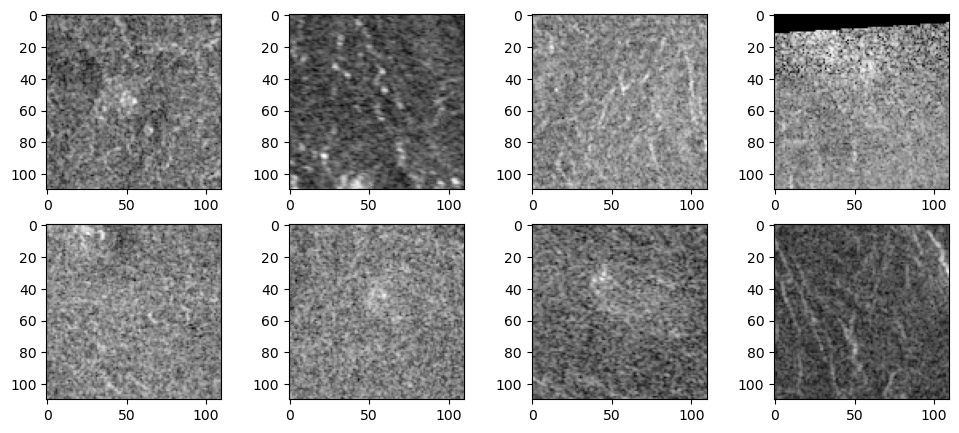

In [21]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 5)
ind = 0

for ax in axs.flat:
    img = np.array(feat.iloc[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

In [22]:
resp.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


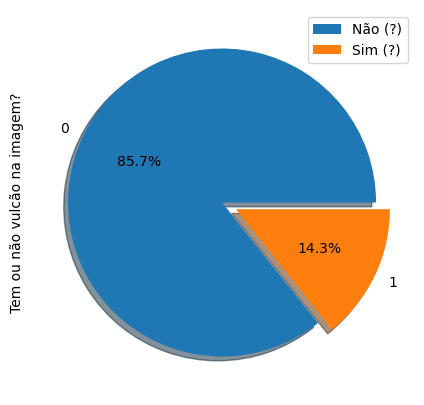

In [23]:
resp['Volcano?'].value_counts().plot(
    kind = 'pie', explode = [0, 0.1], figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
plt.ylabel('Tem ou não vulcão na imagem?')
plt.legend(['Não (?)', 'Sim (?)'])
plt.show()

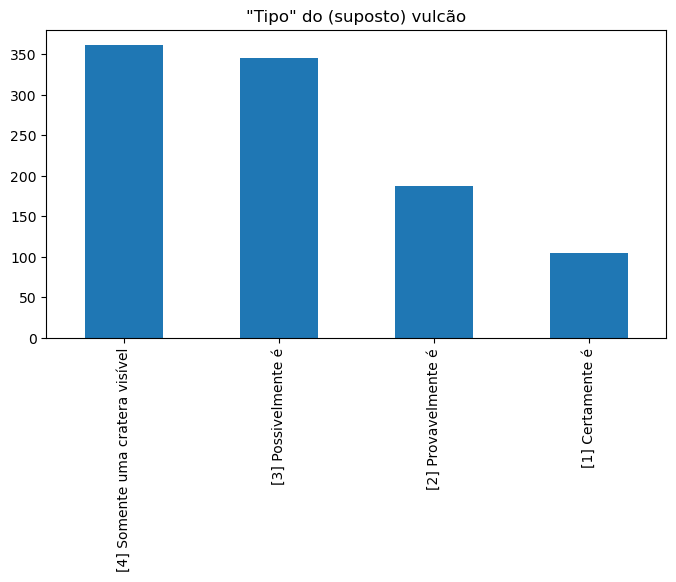

In [24]:
resp[resp['Volcano?'] == 1]['Type'].value_counts().plot(kind = 'bar', legend = False, figsize = (8, 4))
plt.title('"Tipo" do (suposto) vulcão')
plt.xticks(np.arange(4), ['[4] Somente uma cratera visível', '[3] Possivelmente é', '[2] Provavelmente é', '[1] Certamente é'])
plt.show()

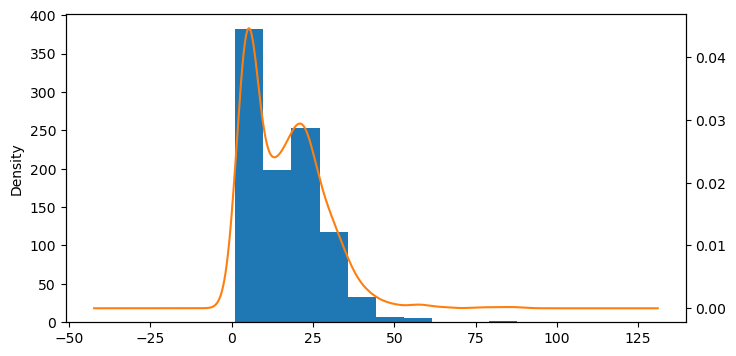

In [25]:
ax = resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'hist', legend = False, figsize = (8, 4))
resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'kde', ax = ax, secondary_y = True)
plt.show()

<Axes: xlabel='Number Volcanoes', ylabel='Count'>

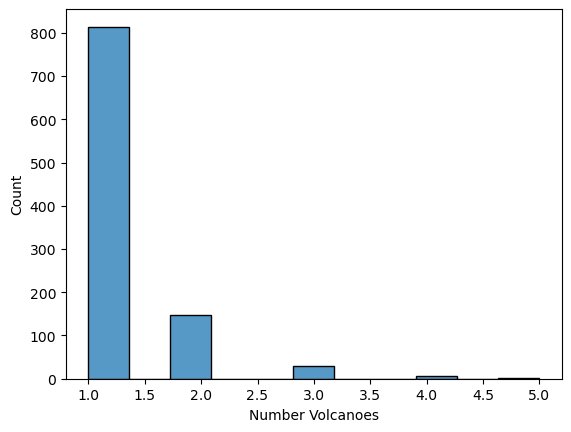

In [26]:
sns.histplot(resp,x='Number Volcanoes')


(Adicionando um gráfico de número de vulcões, que não estava presente na análise. Como podemos ver, a grande maioria das imagens só contém um vulcão.)

== IMAGEM SEM VULCÃO ==
Volcano?            0.0
Type                NaN
Radius              NaN
Number Volcanoes    NaN
Name: 1, dtype: float64


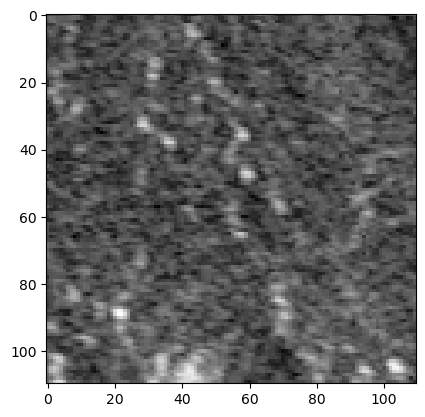

In [27]:
print('== IMAGEM SEM VULCÃO ==')

print(resp.iloc[1])

image = np.array(feat.iloc[1]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

(Uma imagem está bom)

In [28]:
feat_test = pd.read_csv('test_images.csv', header = None)
resp_test = pd.read_csv('test_labels.csv')

## ⚙️ Processando os dados: <a class='anchor' id='processando'></a> [↑](#top)

Copiando os datasets para evitar problemas:

In [29]:
feat_copy = feat.copy(deep=True)
resp_copy = resp.copy(deep=True)

Vendo se está tudo ok com os datasets (dados faltantes, errados, etc.):

In [30]:
feat_copy.isna().sum().sum()

0

In [31]:
resp_copy.describe()

,Volcano?,Type,Radius,Number Volcanoes
count,7000.000000,1000.000000,1000.000000,1000.000000
mean,0.142857,2.965000,16.257650,1.236000
std,0.349952,0.984248,11.632887,0.553724
min,0.000000,1.000000,1.000000,1.000000
25%,0.000000,2.000000,5.830000,1.000000
50%,0.000000,3.000000,14.870000,1.000000
75%,0.000000,4.000000,23.555001,1.000000
max,1.000000,4.000000,87.660000,5.000000


Não parece haver nada de errado com os dados, o que é um bom sinal. No entanto, ainda precisamos resolver alguns problemas: o conjunto de dados é muito grande, o que pode tornar a realização de previsões inviável computacionalmente para alguns modelos. Além disso, a quantidade absurda de "features", maior que o número de observações, além de piorar o processamento, também pode prejudicar alguns modelos e causar overfitting.

Como o objetivo do trabalho é apenas identificar a presença de um vulcão ou não nas imagens, dado que todas as imagens com vulcões possuem um vulcão em seu centro e a grande maioria possui apenas um vulcão, pode ser interessante recortar um pedaço do centro das imagens para diminuir o número de pixels, que são nossas covariáveis. Como o raio médio dos vulcões é de 16.25 pixeis segundo a tabela acima, parece razoável tomar um quadrado de lado 17 (arredondando o raio pra cima), para podermos continuar cobrindo uma parte significativa dos vulcões nas imagens. Isso reduzirá nosso número total de covariáveis de $110^2 = 12100$ para $17^2 = 289$, reduzindo dramáticamente o tempo computacional.

Formatando as imagens:

In [32]:
imagens = np.resize(feat_copy, (7000, 110, 110))

Criando a função de recorte:

In [33]:
def cortar_imagens(imagens, raio):
    imagens_cortadas = []
    for imagem in imagens:
        y,x = imagem.shape
        startx = x//2-(raio//2)
        starty = y//2-(raio//2)    
        imagens_cortadas.append(imagem[starty:starty+raio,startx:startx+raio])
    return imagens_cortadas

Testando a função:

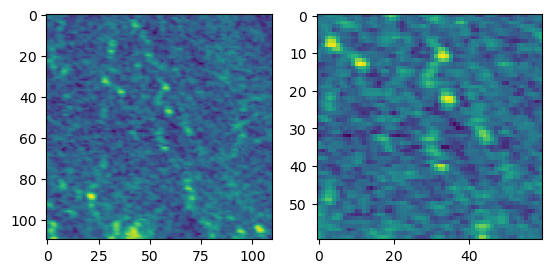

In [34]:
imagens_cortadas = cortar_imagens(imagens, 60)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imagens[1])
ax2.imshow(imagens_cortadas[1])
plt.show()

Podemos perceber que de fato foi dado um zoom no centro, o que indica que a função está funcionando. Fazendo o recorte proposto:

In [35]:
imagens_cortadas = cortar_imagens(imagens, 17)

In [36]:
feat_cortado = np.resize(imagens_cortadas, (7000, 289))
feat_cortado = pd.DataFrame(feat_cortado)
feat_cortado

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
0,114,105,111,118,91,102,110,112,114,119,...,87,81,81,88,95,103,105,91,91,87
1,98,96,99,98,90,84,93,93,91,86,...,89,94,98,101,101,98,93,89,87,79
2,82,81,99,115,116,101,84,93,88,122,...,94,90,76,82,92,104,98,102,82,63
3,74,113,97,113,133,117,111,114,92,93,...,91,77,112,117,107,100,116,98,83,110
4,122,123,121,96,107,116,113,105,124,139,...,117,116,108,115,110,99,117,113,89,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,73,91,94,84,91,83,78,73,83,92,...,78,77,84,113,107,105,106,106,97,83
6996,100,95,97,95,91,63,93,115,110,102,...,91,87,100,94,86,101,100,83,90,87
6997,105,121,127,126,100,101,126,130,134,138,...,115,134,117,146,150,130,119,116,129,141
6998,96,100,104,83,93,81,60,82,99,101,...,96,87,97,92,88,75,95,92,102,90


Comparando o quadrado recortado antes da conversão para dataframe com o pós-conversão, para garantir que tudo ocorreu certo:

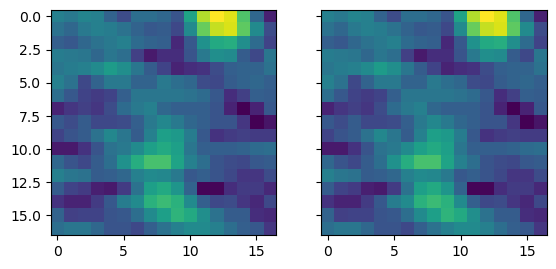

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(imagens_cortadas[1])
ax2.imshow(np.array(feat_cortado.iloc[1]).reshape((17,17)))
plt.show()

Como podemos ver, o recorte funcionou. Com sorte, isto será suficiente para resolver nossos problemas com a densidade da base de dados e o possível overfitting, e conseguiremos bons resultados nas classificações.

## ⚒️ Testando modelos de classificação: <a class='anchor' id='testando'></a> [↑](#top)

#### Renomeando os dados para melhor organização e dividindo a cor dos pixels para deixá-las de 0 a 1:

In [38]:
X_train = feat_cortado.copy(deep=True)/255
y_train = resp['Volcano?']

imagens_teste = np.resize(feat_test, (2734, 110, 110))
imagens_cortadas_teste = cortar_imagens(imagens_teste, 17)
feat_teste_cortado = np.resize(imagens_cortadas_teste, (2734, 289))
feat_teste_cortado = pd.DataFrame(feat_teste_cortado)

X_test = feat_teste_cortado.copy(deep=True)/255
y_test = resp_test['Volcano?']

#### Definindo a função de encaixe dos modelos:

Para diagnosticar os modelos, é necessário levar em consideração o desbalanceamento do conjunto de dados (a grande maioria dos registros não possui vulcão) e qual tipo de erro é mais importante. Quanto ao segundo problema, creio que para a tarefa que estamos realizando isso depende bastante do objetivo por trás de classificar essas imagens (algo que não é especificado no roteiro do trabalho). Dessa forma, optei por utilizar o ROC AUC e a precisão balanceada como as estatísticas de diagnóstico, por considerarem significativamente os 2 tipos de erro e por essa última especificamente penalizar previsões desbalanceadas.

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import FitFailedWarning

resultados = pd.DataFrame(columns=['Modelo', 'Taxa Acerto', 'Score ROC/AUC'])

@ignore_warnings(category=(FitFailedWarning, UserWarning))
def encaixe(modelos, gridsearch=False, parametros={}):
	global resultados

	for modelo in modelos:
		if gridsearch == True:
			param_grid = parametros
			fitado = GridSearchCV(modelo, param_grid,scoring='balanced_accuracy').fit(X_train,y_train)
			print(f'Melhores parâmetros de {type(modelo).__name__} encontrados: {fitado.best_params_}')
		elif gridsearch == False:
			fitado = modelo.fit(X_train,y_train)
		y_pred = fitado.predict(X_test)
		resultados = pd.concat([resultados,pd.DataFrame({'Modelo':[type(modelo).__name__],'Taxa Acerto':[format(1-(y_test != y_pred).sum()/X_test.shape[0],'.2%')],
											  'Score ROC/AUC':[roc_auc_score(y_test, fitado.predict_proba(X_test)[:,1])],
											  'Precisão Balanceada':[balanced_accuracy_score(y_test, y_pred)]})])
	display(resultados)


#### Testando os modelos de Naive Bayes:

In [40]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
modelos=[GaussianNB()]
encaixe(modelos)
modelos = [MultinomialNB(), BernoulliNB(), ComplementNB()]
parametros = dict(alpha=np.linspace(0.01,10,50),force_alpha=[True], fit_prior=[True,False])
encaixe(modelos, gridsearch=True,parametros=parametros)

,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641


Melhores parâmetros de MultinomialNB encontrados: {'alpha': 6.737959183673469, 'fit_prior': False, 'force_alpha': True}
Melhores parâmetros de BernoulliNB encontrados: {'alpha': 0.01, 'fit_prior': True, 'force_alpha': True}
Melhores parâmetros de ComplementNB encontrados: {'alpha': 6.737959183673469, 'fit_prior': True, 'force_alpha': True}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054


Podemos observar que os modelos que assumem distribuição multinomial para as covariáveis performam bem melhor. Faz sentido, dado que a cor dos pixels é uma variável discreta com múltiplos possíveis valores.

#### Testando os modelos de Análise de Discriminantes:

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
modelos = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]
parametros = dict(solver=['svd', 'lsqr', 'eigen'],shrinkage=[None,'auto'])
encaixe([LinearDiscriminantAnalysis()], gridsearch=True, parametros=parametros)
parametros = dict(reg_param = np.linspace(0,1,50))
encaixe([QuadraticDiscriminantAnalysis()], gridsearch=True, parametros=parametros)


Melhores parâmetros de LinearDiscriminantAnalysis encontrados: {'shrinkage': None, 'solver': 'svd'}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672


Melhores parâmetros de QuadraticDiscriminantAnalysis encontrados: {'reg_param': 0.02040816326530612}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672
0,QuadraticDiscriminantAnalysis,91.95%,0.938824,0.760564


Conseguimos maior taxa de acerto e ROC/AUC com esses modelos, mas a custo de precisão balanceada. Talvez encontremos modelos mais interessantes a seguir.

#### Testando o KNN:

In [42]:
from sklearn.neighbors import KNeighborsClassifier
modelos = [KNeighborsClassifier()]
parametros = dict(n_neighbors = range(1,51), weights = ['uniform','distance'])
encaixe(modelos, gridsearch=True, parametros=parametros)

Melhores parâmetros de KNeighborsClassifier encontrados: {'n_neighbors': 1, 'weights': 'uniform'}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672
0,QuadraticDiscriminantAnalysis,91.95%,0.938824,0.760564
0,KNeighborsClassifier,93.01%,0.825753,0.825753


#### Testando o SVC:

In [43]:
from sklearn.svm import SVC
modelos = [SVC(probability=True)]
parametros = dict(kernel=['linear', 'poly', 'rbf', 'sigmoid'])
encaixe(modelos, gridsearch=True, parametros=parametros)

Melhores parâmetros de SVC encontrados: {'kernel': 'poly'}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672
0,QuadraticDiscriminantAnalysis,91.95%,0.938824,0.760564
0,KNeighborsClassifier,93.01%,0.825753,0.825753
0,SVC,95.14%,0.941078,0.883227


Até agora, o SVC polinomial é sem dúvidas o melhor modelo, apresentando melhor pontuação em todos os critérios.

#### Testando os modelos baseados em árvores:

In [44]:
from sklearn.tree import DecisionTreeClassifier
modelos = [DecisionTreeClassifier(random_state=1)]
parametros=dict(max_depth = [0,1,2,3], min_samples_leaf = [0,1,3,5], ccp_alpha=np.logspace(-3,0,num=20))
encaixe(modelos, gridsearch=True, parametros=parametros)

Melhores parâmetros de DecisionTreeClassifier encontrados: {'ccp_alpha': 0.001, 'max_depth': 3, 'min_samples_leaf': 1}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672
0,QuadraticDiscriminantAnalysis,91.95%,0.938824,0.760564
0,KNeighborsClassifier,93.01%,0.825753,0.825753
0,SVC,95.14%,0.941078,0.883227
0,DecisionTreeClassifier,89.43%,0.711261,0.683875


Usando os hiperparâmetros encontrados para a decisiontree no bagging:

In [45]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

modelos = [BaggingClassifier(DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, ccp_alpha=0.001, random_state=1))]
parametros = dict(n_estimators = range(1,21))
encaixe(modelos, gridsearch=True, parametros=parametros)

Melhores parâmetros de BaggingClassifier encontrados: {'n_estimators': 2}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672
0,QuadraticDiscriminantAnalysis,91.95%,0.938824,0.760564
0,KNeighborsClassifier,93.01%,0.825753,0.825753
0,SVC,95.14%,0.941078,0.883227
0,DecisionTreeClassifier,89.43%,0.711261,0.683875
0,BaggingClassifier,88.77%,0.756803,0.676223


In [46]:
modelos = [RandomForestClassifier(random_state=1)]
parametros = dict(n_estimators = range(10, 200, 10))
encaixe(modelos, gridsearch=True, parametros=parametros)

Melhores parâmetros de RandomForestClassifier encontrados: {'n_estimators': 150}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672
0,QuadraticDiscriminantAnalysis,91.95%,0.938824,0.760564
0,KNeighborsClassifier,93.01%,0.825753,0.825753
0,SVC,95.14%,0.941078,0.883227
0,DecisionTreeClassifier,89.43%,0.711261,0.683875
0,BaggingClassifier,88.77%,0.756803,0.676223


Como podemos observar, o SVC performou melhor que os outros modelos em todos os critérios (com o ROC/AUC um pouco menor que o do RandomForest), e apresentou resultados muito bons num geral, mesmo com a redução drástica no número de features. Além disso, a redução funcionou muito bem para reduzir o tempo computacional, permitindo a realização de validação-cruzada nos hiperparâmetros de todos os modelos testados. Será que conseguimos melhorar ainda mais o SVC testando outros graus de polinômio?

In [47]:
modelos = [SVC(probability=True, kernel='poly')]
parametros = dict(degree = range(1,4))
encaixe(modelos, gridsearch=True, parametros=parametros)

Melhores parâmetros de SVC encontrados: {'degree': 3}


,Modelo,Taxa Acerto,Score ROC/AUC,Precisão Balanceada
0,GaussianNB,49.63%,0.653551,0.600641
0,MultinomialNB,89.76%,0.867563,0.840054
0,BernoulliNB,19.06%,0.518913,0.518913
0,ComplementNB,89.76%,0.867563,0.840054
0,LinearDiscriminantAnalysis,91.73%,0.872363,0.767672
0,QuadraticDiscriminantAnalysis,91.95%,0.938824,0.760564
0,KNeighborsClassifier,93.01%,0.825753,0.825753
0,SVC,95.14%,0.941078,0.883227
0,DecisionTreeClassifier,89.43%,0.711261,0.683875
0,BaggingClassifier,88.77%,0.756803,0.676223


Aparentemente o GridSearchCV encontrou 3 como o melhor grau usando a Precisão Balanceada como score (3 é o valor padrão do modelo). Mesmo assim, considerando as pontuações encontradas, parece razoável escolher o SVC como modelo para ser utilizado em futuras identificações.